In [43]:
## Load the libraries required for random forest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pylab as pylab
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

In [44]:
## load the data stored in the path specified
df = pd.read_table('/Users/subasrees/Desktop/Omics-analysis/intro-machine-learning-training/exam/heartData_simplified.csv',sep=',')
df.head()

,age,sex,chol,thalach,oldpeak,ca,thal,target
0,63,male,233,150,2.3,0,defect,no
1,37,male,250,187,3.5,0,normal,no
2,41,female,204,172,1.4,0,normal,no
3,56,male,236,178,0.8,0,normal,no
4,57,female,354,163,0.6,0,normal,no


In [45]:
df['thal'] = df['thal'].astype(pd.CategoricalDtype(categories=["normal", "reversible", "defect"],ordered=True))

# get dummies will transform these categorical columns to sets of 0/1 columns
df = pd.get_dummies( df , drop_first=True )

In [46]:
## Specify the features and the response
X_diabetes=df.iloc[:,:len(df.columns)-1]
y_diabetes=df.target_yes

In [47]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(X_diabetes, 
                                                                                y_diabetes,
                                                                                random_state=7,
                                                                                stratify=y_diabetes) 

print("number of samples:")
print( f"\tfull  dataset: {len(y_diabetes)}" )
print( f"\ttrain dataset: {len(y_diabetes_train)}" )
print( f"\ttest  dataset: {len(y_diabetes_test)}" )


# train_test_split stratify make sure to split the data such 
# that the two partitions have similar proportion of each target classes
print("\nproportion of diabtes:")
print( f"\tfull  dataset: {y_diabetes.mean():.3f}" )
print( f"\ttrain dataset: {y_diabetes_train.mean():.3f}" )
print( f"\ttest  dataset: {y_diabetes_test.mean():.3f}" )

number of samples:
	full  dataset: 296
	train dataset: 222
	test  dataset: 74

proportion of diabtes:
	full  dataset: 0.459
	train dataset: 0.459
	test  dataset: 0.459


In [48]:
## first we split in train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_train, 
                                                      y_diabetes_train,
                                                      random_state=13245,
                                                      test_size=0.3,
                                                      stratify=y_diabetes_train) 

## scaling 
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.fit_transform(X_valid)

In [49]:
from sklearn.metrics import confusion_matrix,accuracy_score
grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':[25,50,75,100], 
               'max_depth':[2,6],
               'min_samples_split':[10,50],
              'min_samples_leaf':[10,20]}

grid_rf_roc_auc = GridSearchCV(RandomForestClassifier(n_jobs=-1,class_weight='balanced'), 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_rf_roc_auc.fit(X_train_norm, y_train)

y_decision_fn_scores_roc_auc=grid_rf_roc_auc.score(X_valid_norm, y_valid)


print(f'Grid best score (roc_auc_ovr_weighted): {grid_rf_roc_auc.best_score_:.3f}')
print('Grid best parameter (max. roc_auc_ovr_weighted): ')
for k,v in grid_rf_roc_auc.best_params_.items():
    print('\t',k,'->',v)

Grid best score (roc_auc_ovr_weighted): 0.886
Grid best parameter (max. roc_auc_ovr_weighted): 
	 criterion -> entropy
	 max_depth -> 6
	 min_samples_leaf -> 20
	 min_samples_split -> 10
	 n_estimators -> 100


Text(0.5, 14.722222222222216, 'Predicted label')

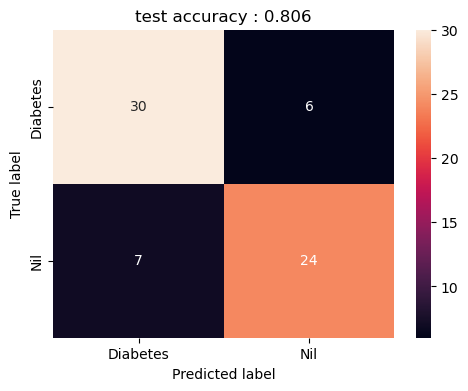

In [50]:
## predicting the labels on the test set    
y_pred_test_diabetes=grid_rf_roc_auc.predict(X_valid_norm)

confusion_m_cancer = confusion_matrix(y_valid, y_pred_test_diabetes)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_m_cancer, annot=True , 
            xticklabels=['Diabetes','Nil'], 
            yticklabels=['Diabetes','Nil'])
plt.title('test {} : {:.3f}'.format( "accuracy" , 
                                    accuracy_score(y_valid,y_pred_test_diabetes)  ))
plt.ylabel('True label')
plt.xlabel('Predicted label')



In [51]:
RF = grid_rf_roc_auc.best_estimator_

w=RF.feature_importances_#get the weights

featureW = pd.DataFrame( {'feature': X_diabetes.columns,'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance:


,feature,weight
3,oldpeak,0.235918
4,ca,0.235659
2,thalach,0.213348
6,thal_reversible,0.141761
0,age,0.110057
1,chol,0.045956
5,sex_male,0.017301


In [52]:
## Removing the last two features which contribute less to the response 
df_diabetes_remove=df.drop(['sex_male','chol'],axis=1)

In [53]:
X_diabetes_remove=df_diabetes_remove.iloc[:,:len(df_diabetes_remove.columns)-1]
y_diabetes_remove=df_diabetes_remove.target_yes

In [54]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_diabetes_train_remove, X_diabetes_test_remove, y_diabetes_train_remove, y_diabetes_test_remove, = train_test_split(X_diabetes_remove, 
                                                                                y_diabetes_remove,
                                                                                random_state=7,
                                                                                stratify=y_diabetes_remove) 

print("number of samples:")
print( f"\tfull  dataset: {len(y_diabetes_remove)}" )
print( f"\ttrain dataset: {len(y_diabetes_train_remove)}" )
print( f"\ttest  dataset: {len(y_diabetes_test_remove,)}" )


# train_test_split stratify make sure to split the data such 
# that the two partitions have similar proportion of each target classes
print("\nproportion of diabtes:")
print( f"\tfull  dataset: {y_diabetes_remove.mean():.3f}" )
print( f"\ttrain dataset: {y_diabetes_train_remove.mean():.3f}" )
print( f"\ttest  dataset: {y_diabetes_test_remove.mean():.3f}" )



number of samples:
	full  dataset: 296
	train dataset: 222
	test  dataset: 74

proportion of diabtes:
	full  dataset: 0.459
	train dataset: 0.459
	test  dataset: 0.459


In [55]:
## first we split in train and valid
X_train_remove, X_valid_remove, y_train_remove, y_valid_remove = train_test_split(X_diabetes_remove, 
                                                      y_diabetes_remove,
                                                      random_state=13245,
                                                      test_size=0.3,
                                                      stratify=y_diabetes_remove) 

## scaling 
scaler = StandardScaler()
X_train_norm_remove = scaler.fit_transform(X_train_remove)
X_valid_norm_remove = scaler.fit_transform(X_valid_remove)

In [56]:
from sklearn.metrics import confusion_matrix,accuracy_score
grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':[25,50,75,100], 
               'max_depth':[2,6],
               'min_samples_split':[10,50],
              'min_samples_leaf':[10,20]}

grid_rf_roc_auc = GridSearchCV(RandomForestClassifier(n_jobs=-1,class_weight='balanced'), 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_rf_roc_auc.fit(X_train_norm_remove, y_train_remove)

y_decision_fn_scores_roc_auc=grid_rf_roc_auc.score(X_valid_norm_remove, y_valid_remove)


print(f'Grid best score (roc_auc_ovr_weighted): {grid_rf_roc_auc.best_score_:.3f}')
print('Grid best parameter (max. roc_auc_ovr_weighted): ')
for k,v in grid_rf_roc_auc.best_params_.items():
    print('\t',k,'->',v)

Grid best score (roc_auc_ovr_weighted): 0.895
Grid best parameter (max. roc_auc_ovr_weighted): 
	 criterion -> gini
	 max_depth -> 6
	 min_samples_leaf -> 20
	 min_samples_split -> 50
	 n_estimators -> 25


Text(0.5, 14.722222222222216, 'Predicted label')

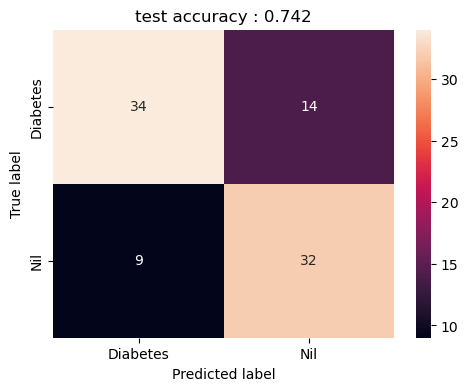

In [57]:
## predicting the labels on the test set    
y_pred_test_diabetes_remove=grid_rf_roc_auc.predict(X_valid_norm_remove)

confusion_m_cancer = confusion_matrix(y_valid_remove, y_pred_test_diabetes_remove)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_m_cancer, annot=True , 
            xticklabels=['Diabetes','Nil'], 
            yticklabels=['Diabetes','Nil'])
plt.title('test {} : {:.3f}'.format( "accuracy" , 
                                    accuracy_score(y_valid_remove,y_pred_test_diabetes_remove)  ))
plt.ylabel('True label')
plt.xlabel('Predicted label')



In [58]:
RF = grid_rf_roc_auc.best_estimator_

w=RF.feature_importances_#get the weights

featureW = pd.DataFrame( {'feature': X_diabetes_remove.columns,'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance:


,feature,weight
3,ca,0.343589
1,thalach,0.229361
2,oldpeak,0.223970
4,thal_reversible,0.160482
0,age,0.042598


Conclusions
1. The random forest also did not yield a satisfactory prediction (~0.82)
2. Removing the three features which had very less weights did not improve the accuracy, it worsened the relationship between the features and the response
3. Both the datasets performed best with 75 estimators